# Exploratory Data Analysis - PySpark

Análise Exploratória dos Dados do ENEM entre 2017 e 2019. Não serão plotados mapas coropléticos neste notebook, porém serão gerados arquivos .csv para a confecção de tais mapas em outro software ou notebook a fim de evitar a sobrecarga deste.

# Setup

In [ ]:
# Necessário REINICIAR o Ambiente de Execução após instalar a execução desta célula!
!pip install plotly==4.14.3 # Versão mais recente e com suporte a geojson
!pip install pandas==1.3.0  #
!pip install -U kaleido     # Engine para exportar imagens estáticas no plotly
!sudo apt update            # Atualizando apt para obter java

Instalando PySpark

In [1]:
# instalando as dependências    -- leva uns minutinhos
!apt-get install openjdk-8-jdk-headless -qq > /dev/null   # Instalando Java
!wget -q !wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz # Download Apache Spark
!tar xf spark-3.1.2-bin-hadoop3.2.tgz   # Descompactando a pasta do Apache Spark
!pip install -q findspark               # Instalando módulo para "achar" o Spark
!pip install -q pyspark                 # Instalando a API do Spark para Python

     |████████████████████████████████| 212.4 MB 70 kB/s 
     |████████████████████████████████| 198 kB 63.3 MB/s 


In [2]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

# tornar o pyspark "importável"
import findspark
findspark.init('spark-3.1.2-bin-hadoop3.2')

# Criando sessão spark
from pyspark.sql import SparkSession
sc = SparkSession.builder.master('local[*]').getOrCreate()

Montando o Google Drive

In [ ]:
## ATENÇÃO! Aparecerá um link externo seguro provido automaticamente pelo Google Colab para que seja 
## gerado o código de autenticação necessário para o acesso ao Drive.

if not os.path.exists('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')

# Data Collecting

Coletando os dados pré-processados de cada ano

In [3]:
# download do http para arquivo local
last_year = 2019
data_path = [f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Dados/PRE_PROCESSED_ENEM_{anos}.pq' \
             for anos in range(2017, last_year+1)]
data_path

['/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Dados/PRE_PROCESSED_ENEM_2017.pq',
 '/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Dados/PRE_PROCESSED_ENEM_2018.pq',
 '/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Dados/PRE_PROCESSED_ENEM_2019.pq']

In [4]:
# carregar dados pré-processados do ENEM
df = sc.read.parquet(*data_path, inferSchema=True, header=True, encoding='latin-1').drop('Q026', 'Q027')

In [5]:
# Total de linhas
from pyspark.sql.functions import count
df.count()

16850882

# Exploratory Data Analysis

In [6]:
import plotly as py
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import math
import numpy as np
import pandas as pd
from scipy.stats import shapiro, anderson, normaltest, levene
from pyspark.sql.functions import col, sum, mean

In [7]:
# Criando mapa de UF e respectiva região
uf_centroeste = ['DF', 'GO', 'MS', 'MT']
uf_nordeste   = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
uf_norte      = ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO']
uf_sudeste    = ['ES', 'MG', 'RJ', 'SP']
uf_sul        = ['PR', 'RS', 'SC']

map_uf_regiao = {
    **dict.fromkeys(uf_centroeste, 'Centro-Oeste'), 
    **dict.fromkeys(uf_nordeste, 'Nordeste'),
    **dict.fromkeys(uf_norte, 'Norte'),
    **dict.fromkeys(uf_sudeste, 'Sudeste'),
    **dict.fromkeys(uf_sul, 'Sul')
}

In [8]:
# Dicionário de Respostas de TP_COR_RACA
TP_COR_RACA_map = {
    0: 'Não Declarada',
    1: 'Branca',
    2: 'Preta',
    3: 'Parda',
    4: 'Amarela',
    5: 'Indígena'
}

## Eixo X: Raça

2017

In [11]:
df_raça_2017 = df[df['NU_ANO']=='2017']\
.select('TP_COR_RACA', 'SG_UF_PROVA','NU_NOTA_MEDIA')\
.where("NU_NOTA_MEDIA > 0.0")\
.toPandas()

In [12]:
df_raça_2017['Região'] = df_raça_2017['SG_UF_PROVA'].map(map_uf_regiao)
df_raça_2017['TP_COR_RACA'] = df_raça_2017['TP_COR_RACA'].map(TP_COR_RACA_map)
df_raça_2017.head()

,TP_COR_RACA,SG_UF_PROVA,NU_NOTA_MEDIA,Região
0,Parda,PB,593.80,Nordeste
1,Preta,PA,416.54,Norte
2,Preta,SP,562.50,Sudeste
3,Preta,MG,505.06,Sudeste
4,Parda,PR,416.96,Sul


In [13]:
raça_2017 = df_raça_2017 \
.groupby(['TP_COR_RACA', 'Região'])['NU_NOTA_MEDIA'] \
.mean()

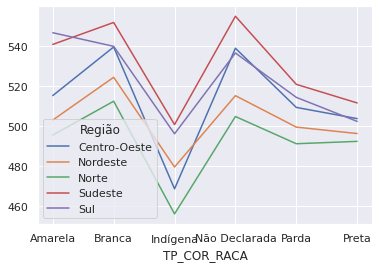

In [14]:
raça_2017.unstack().plot()

In [15]:
raça_2017.unstack()

Região,Centro-Oeste,Nordeste,Norte,Sudeste,Sul
TP_COR_RACA,,,,,
Amarela,515.201218,503.000367,495.496529,540.725830,546.553171
Branca,539.451408,524.339155,512.386768,551.681954,539.769658
Indígena,468.679837,479.561737,456.171728,500.746044,496.137086
Não Declarada,538.822164,515.165324,504.758604,554.780012,536.454866
Parda,509.303621,499.475332,491.179631,520.809403,514.324974
Preta,503.708992,496.263432,492.361301,511.533911,502.331781


In [ ]:
raça_2017.unstack()['Nordeste']

TP_COR_RACA
Amarela          503.000367
Branca           524.339155
Indígena         479.561737
Não Declarada    515.165324
Parda            499.475332
Preta            496.263432
Name: Nordeste, dtype: float64

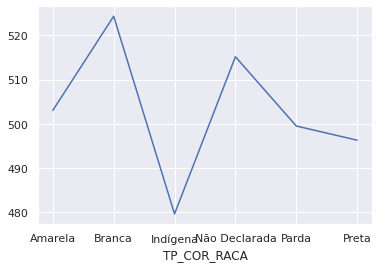

In [ ]:
raça_2017.unstack()['Nordeste'].plot()

In [ ]:
# Limpando a variável para liberar memória
df_raça_2017 = ''

2018

In [16]:
df_raça_2018 = df[df['NU_ANO']=='2018']\
.select('TP_COR_RACA', 'SG_UF_PROVA','NU_NOTA_MEDIA')\
.where("NU_NOTA_MEDIA > 0.0")\
.toPandas()

In [17]:
df_raça_2018['Região'] = df_raça_2018['SG_UF_PROVA'].map(map_uf_regiao)
df_raça_2018['TP_COR_RACA'] = df_raça_2018['TP_COR_RACA'].map(TP_COR_RACA_map)
df_raça_2018.head()

,TP_COR_RACA,SG_UF_PROVA,NU_NOTA_MEDIA,Região
0,Branca,RS,547.40,Sul
1,Parda,PA,537.90,Norte
2,Parda,MA,528.70,Nordeste
3,Indígena,MS,441.34,Centro-Oeste
4,Parda,MA,474.72,Nordeste


In [18]:
raça_2018 = df_raça_2018 \
.groupby(['TP_COR_RACA', 'Região'])['NU_NOTA_MEDIA'] \
.mean()

In [19]:
raça_2018.unstack()

Região,Centro-Oeste,Nordeste,Norte,Sudeste,Sul
TP_COR_RACA,,,,,
Amarela,521.588358,511.938444,504.296676,555.650544,553.894318
Branca,550.287951,536.703886,522.629080,566.291792,548.532973
Indígena,470.057819,486.027326,468.126141,510.090750,496.855728
Não Declarada,543.472399,522.621788,510.886302,564.005059,543.165652
Parda,515.879866,508.872106,499.091506,531.078069,521.571530
Preta,509.569621,504.606734,498.459776,520.798647,508.556159


2019

In [20]:
df_raça_2019 = df[df['NU_ANO']=='2019']\
.select('TP_COR_RACA', 'SG_UF_PROVA','NU_NOTA_MEDIA')\
.where("NU_NOTA_MEDIA > 0.0")\
.toPandas()

In [21]:
df_raça_2019['Região'] = df_raça_2019['SG_UF_PROVA'].map(map_uf_regiao)
df_raça_2019['TP_COR_RACA'] = df_raça_2019['TP_COR_RACA'].map(TP_COR_RACA_map)
df_raça_2019.head()

,TP_COR_RACA,SG_UF_PROVA,NU_NOTA_MEDIA,Região
0,Branca,MG,657.78,Sudeste
1,Parda,MG,683.46,Sudeste
2,Branca,MG,487.78,Sudeste
3,Parda,MG,559.92,Sudeste
4,Parda,MG,488.86,Sudeste


In [22]:
raça_2019 = df_raça_2019 \
.groupby(['TP_COR_RACA', 'Região'])['NU_NOTA_MEDIA'] \
.mean()

In [23]:
raça_2019.unstack()

Região,Centro-Oeste,Nordeste,Norte,Sudeste,Sul
TP_COR_RACA,,,,,
Amarela,514.710001,503.722590,494.897932,548.453785,546.522020
Branca,546.133577,534.423131,517.769192,561.612391,543.576387
Indígena,459.675837,476.315506,456.900026,497.792811,491.515219
Não Declarada,536.448699,509.645952,502.006431,555.901665,533.918912
Parda,508.977625,502.773253,491.004735,523.345381,514.878922
Preta,501.560622,496.536211,491.827173,512.696193,502.248794


Plots

In [24]:
x = raça_2017.unstack().index,raça_2018.unstack().index,raça_2019.unstack().index

In [25]:
fig = go.Figure()

# LINE
fig.add_traces(
    [go.Scatter(
        name='Centro-Oeste',
        x=[
           np.NaN,1,2,3,
           np.NaN,4,5,6,
           np.NaN,7,8,9,
           np.NaN,10,11,12,
           np.NaN,13,14,15,
           np.NaN,16,17,18
        ],
        y=[
           np.NaN,raça_2017.unstack()['Centro-Oeste'].values.tolist()[0],raça_2018.unstack()['Centro-Oeste'].values.tolist()[0],raça_2019.unstack()['Centro-Oeste'].values.tolist()[0],
           np.NaN,raça_2017.unstack()['Centro-Oeste'].values.tolist()[1],raça_2018.unstack()['Centro-Oeste'].values.tolist()[1],raça_2019.unstack()['Centro-Oeste'].values.tolist()[1],
           np.NaN,raça_2017.unstack()['Centro-Oeste'].values.tolist()[2],raça_2018.unstack()['Centro-Oeste'].values.tolist()[2],raça_2019.unstack()['Centro-Oeste'].values.tolist()[2],
           np.NaN,raça_2017.unstack()['Centro-Oeste'].values.tolist()[3],raça_2018.unstack()['Centro-Oeste'].values.tolist()[3],raça_2019.unstack()['Centro-Oeste'].values.tolist()[3],
           np.NaN,raça_2017.unstack()['Centro-Oeste'].values.tolist()[4],raça_2018.unstack()['Centro-Oeste'].values.tolist()[4],raça_2019.unstack()['Centro-Oeste'].values.tolist()[4],
           np.NaN,raça_2017.unstack()['Centro-Oeste'].values.tolist()[5],raça_2018.unstack()['Centro-Oeste'].values.tolist()[5],raça_2019.unstack()['Centro-Oeste'].values.tolist()[5],
        ],
        mode='lines',
        line = dict(color='#264653'),
        showlegend=True
    ),
     go.Scatter(
        name='Nordeste',
        x=[
           np.NaN,1,2,3,
           np.NaN,4,5,6,
           np.NaN,7,8,9,
           np.NaN,10,11,12,
           np.NaN,13,14,15,
           np.NaN,16,17,18
        ],
        y=[
           np.NaN,raça_2017.unstack()['Nordeste'].values.tolist()[0],raça_2018.unstack()['Nordeste'].values.tolist()[0],raça_2019.unstack()['Nordeste'].values.tolist()[0],
           np.NaN,raça_2017.unstack()['Nordeste'].values.tolist()[1],raça_2018.unstack()['Nordeste'].values.tolist()[1],raça_2019.unstack()['Nordeste'].values.tolist()[1],
           np.NaN,raça_2017.unstack()['Nordeste'].values.tolist()[2],raça_2018.unstack()['Nordeste'].values.tolist()[2],raça_2019.unstack()['Nordeste'].values.tolist()[2],
           np.NaN,raça_2017.unstack()['Nordeste'].values.tolist()[3],raça_2018.unstack()['Nordeste'].values.tolist()[3],raça_2019.unstack()['Nordeste'].values.tolist()[3],
           np.NaN,raça_2017.unstack()['Nordeste'].values.tolist()[4],raça_2018.unstack()['Nordeste'].values.tolist()[4],raça_2019.unstack()['Nordeste'].values.tolist()[4],
           np.NaN,raça_2017.unstack()['Nordeste'].values.tolist()[5],raça_2018.unstack()['Nordeste'].values.tolist()[5],raça_2019.unstack()['Nordeste'].values.tolist()[5],
        ],
        mode='lines',
        line = dict(color='#2a9d8f'),
        showlegend=True
    ),
     go.Scatter(
        name='Norte',
        x=[
           np.NaN,1,2,3,
           np.NaN,4,5,6,
           np.NaN,7,8,9,
           np.NaN,10,11,12,
           np.NaN,13,14,15,
           np.NaN,16,17,18
        ],
        y=[
           np.NaN,raça_2017.unstack()['Norte'].values.tolist()[0],raça_2018.unstack()['Norte'].values.tolist()[0],raça_2019.unstack()['Norte'].values.tolist()[0],
           np.NaN,raça_2017.unstack()['Norte'].values.tolist()[1],raça_2018.unstack()['Norte'].values.tolist()[1],raça_2019.unstack()['Norte'].values.tolist()[1],
           np.NaN,raça_2017.unstack()['Norte'].values.tolist()[2],raça_2018.unstack()['Norte'].values.tolist()[2],raça_2019.unstack()['Norte'].values.tolist()[2],
           np.NaN,raça_2017.unstack()['Norte'].values.tolist()[3],raça_2018.unstack()['Norte'].values.tolist()[3],raça_2019.unstack()['Norte'].values.tolist()[3],
           np.NaN,raça_2017.unstack()['Norte'].values.tolist()[4],raça_2018.unstack()['Norte'].values.tolist()[4],raça_2019.unstack()['Norte'].values.tolist()[4],
           np.NaN,raça_2017.unstack()['Norte'].values.tolist()[5],raça_2018.unstack()['Norte'].values.tolist()[5],raça_2019.unstack()['Norte'].values.tolist()[5],
        ],
        mode='lines',
        line = dict(color='#e9c46a'),
        showlegend=True
    ),
     go.Scatter(
        name='Sudeste',
        x=[
           np.NaN,1,2,3,
           np.NaN,4,5,6,
           np.NaN,7,8,9,
           np.NaN,10,11,12,
           np.NaN,13,14,15,
           np.NaN,16,17,18
        ],
        y=[
           np.NaN,raça_2017.unstack()['Sudeste'].values.tolist()[0],raça_2018.unstack()['Sudeste'].values.tolist()[0],raça_2019.unstack()['Sudeste'].values.tolist()[0],
           np.NaN,raça_2017.unstack()['Sudeste'].values.tolist()[1],raça_2018.unstack()['Sudeste'].values.tolist()[1],raça_2019.unstack()['Sudeste'].values.tolist()[1],
           np.NaN,raça_2017.unstack()['Sudeste'].values.tolist()[2],raça_2018.unstack()['Sudeste'].values.tolist()[2],raça_2019.unstack()['Sudeste'].values.tolist()[2],
           np.NaN,raça_2017.unstack()['Sudeste'].values.tolist()[3],raça_2018.unstack()['Sudeste'].values.tolist()[3],raça_2019.unstack()['Sudeste'].values.tolist()[3],
           np.NaN,raça_2017.unstack()['Sudeste'].values.tolist()[4],raça_2018.unstack()['Sudeste'].values.tolist()[4],raça_2019.unstack()['Sudeste'].values.tolist()[4],
           np.NaN,raça_2017.unstack()['Sudeste'].values.tolist()[5],raça_2018.unstack()['Sudeste'].values.tolist()[5],raça_2019.unstack()['Sudeste'].values.tolist()[5],
        ],
        mode='lines',
        line = dict(color='#f4a261'),
        showlegend=True
    ),
    go.Scatter(
        name='Sul',
        x=[
           np.NaN,1,2,3,
           np.NaN,4,5,6,
           np.NaN,7,8,9,
           np.NaN,10,11,12,
           np.NaN,13,14,15,
           np.NaN,16,17,18
        ],
        y=[
           np.NaN,raça_2017.unstack()['Sul'].values.tolist()[0],raça_2018.unstack()['Sul'].values.tolist()[0],raça_2019.unstack()['Sul'].values.tolist()[0],
           np.NaN,raça_2017.unstack()['Sul'].values.tolist()[1],raça_2018.unstack()['Sul'].values.tolist()[1],raça_2019.unstack()['Sul'].values.tolist()[1],
           np.NaN,raça_2017.unstack()['Sul'].values.tolist()[2],raça_2018.unstack()['Sul'].values.tolist()[2],raça_2019.unstack()['Sul'].values.tolist()[2],
           np.NaN,raça_2017.unstack()['Sul'].values.tolist()[3],raça_2018.unstack()['Sul'].values.tolist()[3],raça_2019.unstack()['Sul'].values.tolist()[3],
           np.NaN,raça_2017.unstack()['Sul'].values.tolist()[4],raça_2018.unstack()['Sul'].values.tolist()[4],raça_2019.unstack()['Sul'].values.tolist()[4],
           np.NaN,raça_2017.unstack()['Sul'].values.tolist()[5],raça_2018.unstack()['Sul'].values.tolist()[5],raça_2019.unstack()['Sul'].values.tolist()[5],
        ],
        mode='lines',
        line = dict(color='#e76f51'),
        showlegend=True
    ),
    
    ]
)

# 2017
fig.add_traces(
    [go.Scatter(
        name='2017',
        x = [1,4,7,10,13,16],
        y = raça_2017.unstack()['Centro-Oeste'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#264653'),
        legendgroup = '2017',
        showlegend=False
    ),
     go.Scatter(
        name='2017',
        x = [1,4,7,10,13,16],
        y = raça_2017.unstack()['Nordeste'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#2a9d8f'),
        legendgroup = '2017',
        showlegend=False
    ),
     go.Scatter(
        name='2017',
        x = [1,4,7,10,13,16],
        y = raça_2017.unstack()['Norte'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#e9c46a'),
        legendgroup = '2017',
        showlegend=False
    ),
     go.Scatter(
        name='2017',
        x = [1,4,7,10,13,16],
        y = raça_2017.unstack()['Sudeste'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#f4a261'),
        legendgroup = '2017',
        showlegend=False
    ),
     go.Scatter(
        name='2017',
        x = [1,4,7,10,13,16],
        y = raça_2017.unstack()['Sul'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#e76f51'),
        legendgroup = '2017',
    )]
)

# 2018
fig.add_traces(
    [go.Scatter(
        name='2018',
        x = [2,5,8,11,14,17],
        y = raça_2018.unstack()['Centro-Oeste'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#264653',symbol='square'),
        legendgroup = '2018',
        showlegend=False
    ),
     go.Scatter(
        name='2018',
        x = [2,5,8,11,14,17],
        y = raça_2018.unstack()['Nordeste'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#2a9d8f',symbol='square'),
        legendgroup = '2018',
        showlegend=False
    ),
     go.Scatter(
        name='2018',
        x = [2,5,8,11,14,17],
        y = raça_2018.unstack()['Norte'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#e9c46a',symbol='square'),
        legendgroup = '2018',
        showlegend=False
    ),
     go.Scatter(
        name='2018',
        x = [2,5,8,11,14,17],
        y = raça_2018.unstack()['Sudeste'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#f4a261',symbol='square'),
        legendgroup = '2018',
        showlegend=False
    ),
     go.Scatter(
        name='2018',
        x = [2,5,8,11,14,17],
        y = raça_2018.unstack()['Sul'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#e76f51',symbol='square'),
        legendgroup = '2018',
    )]
)

# 2019
fig.add_traces(
    [go.Scatter(
        name='2019',
        x = [3,6,9,12,15,18],
        y = raça_2019.unstack()['Centro-Oeste'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#264653',symbol='triangle-up'),
        legendgroup = '2019',
        showlegend=False
    ),
     go.Scatter(
        name='2019',
        x = [3,6,9,12,15,18],
        y = raça_2019.unstack()['Nordeste'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#2a9d8f',symbol='triangle-up'),
        legendgroup = '2019',
        showlegend=False
    ),
     go.Scatter(
        name='2019',
        x = [3,6,9,12,15,18],
        y = raça_2019.unstack()['Norte'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#e9c46a',symbol='triangle-up'),
        legendgroup = '2019',
        showlegend=False
    ),
     go.Scatter(
        name='2019',
        x = [3,6,9,12,15,18],
        y = raça_2019.unstack()['Sudeste'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#f4a261',symbol='triangle-up'),
        legendgroup = '2019',
        showlegend=False
    ),
     go.Scatter(
        name='2019',
        x = [3,6,9,12,15,18],
        y = raça_2019.unstack()['Sul'].values.tolist(),
        mode='markers',
        marker=dict(size=12, color='#e76f51',symbol='triangle-up'),
        legendgroup = '2019',
    )]
)


# LAYOUT
fig.update_layout(
    title = dict(
        text='Médias das notas no Enem entre 2017 e 2019<br>de acordo com a Raça Autodeclarada e a Macrorregião',
        font=dict(size=24)
    ),
    yaxis = dict(
        title = dict(
            text='Médias das Notas',
            font=dict(size=22)
        ),
        tickfont=dict(size=18),
    ),
    xaxis = dict(
        title = dict(
            text='Cou ou Raça Autodeclarada',
            font=dict(size=22)
        ),
        tickfont=dict(size=18),
        tickvals=[2,5,8,11,14,17],
        ticktext=raça_2017.unstack().index.values.tolist()
    ),
    legend = dict(
        font=dict(size=16),
        title=dict(text='Legenda', font=dict(size=20)),
    ),
    autosize=True,
    margin = dict(l=0, t=70, r=0, b=0),
    plot_bgcolor = 'white'
)


fig.show()

In [26]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='line',
        x=[
           np.NaN,1,2,3,
           np.NaN,4,5,6,
           np.NaN,7,8,9,
           np.NaN,10,11,12,
           np.NaN,13,14,15
        ],
        y=[
           np.NaN,df_2017.Porcentagem.values.tolist()[0],df_2018.Porcentagem.values.tolist()[0],df_2019.Porcentagem.values.tolist()[0],
           np.NaN,df_2017.Porcentagem.values.tolist()[1],df_2018.Porcentagem.values.tolist()[1],df_2019.Porcentagem.values.tolist()[1],
           np.NaN,df_2017.Porcentagem.values.tolist()[2],df_2018.Porcentagem.values.tolist()[2],df_2019.Porcentagem.values.tolist()[2],
           np.NaN,df_2017.Porcentagem.values.tolist()[3],df_2018.Porcentagem.values.tolist()[3],df_2019.Porcentagem.values.tolist()[3],
           np.NaN,df_2017.Porcentagem.values.tolist()[4],df_2018.Porcentagem.values.tolist()[4],df_2019.Porcentagem.values.tolist()[4],
        ],
        mode='lines',
        line = dict(color='black'),
        showlegend=False
    )
)
fig.add_trace(
    go.Scatter(
        name='2017',
        x = [1,4,7,10,13],
        y = df_2017.Porcentagem,
        mode='markers+text',
        marker=dict(size=12, color='#e63946'),
        text=df_2017.Quantidade,
        texttemplate='<b>%{text:.2s}</b>',
        textposition='top center',
        textfont=dict(size=18),
        legendgroup = '2017',
    )
)
fig.add_trace(
    go.Scatter(
        name='2018',
        x = [2,5,8,11,14],
        y = df_2018.Porcentagem,
        mode='markers+text',
        marker=dict(size=12, color='#2a9d8f'),
        text=df_2018.Quantidade,
        texttemplate='<b>%{text:.2s}</b>',
        textposition=['top center','bottom center','bottom center','bottom center','bottom center'],
        textfont=dict(size=18),
        legendgroup = '2018',
    )
)
fig.add_trace(
    go.Scatter(
        name='2019',
        x = [3,6,9,12,15],
        y = df_2019.Porcentagem,
        mode='markers+text',
        marker=dict(size=12, color='#1d3557'),
        text=df_2019.Quantidade,
        texttemplate='<b>%{text:.2s}</b>',
        textposition='top center',
        textfont=dict(size=18),
        legendgroup = '2019',
    )
)


fig.update_layout(
    title = dict(
        text='Proporção de Dados Faltantes<br>sobre o Enem entre 2017 e 2019',
        font=dict(size=24)
    ),
    yaxis = dict(
        title = dict(
            text='Proporção de Dados Faltantes',
            font=dict(size=22)
        ),
        tickfont=dict(size=18),
        ticksuffix='%',
        range=[-5,85],
    ),
    xaxis = dict(
        title = dict(
            text='Variáveis Principais',
            font=dict(size=22)
        ),
        tickfont=dict(size=18),
        tickvals=[2,5,8,11,14],
        ticktext=df_2017.Variável.values.tolist()
    ),
    legend = dict(
        font=dict(size=16),
        title=dict(text='Ano', font=dict(size=20)),
        x=0.95,
        y=0.5
    ),
    autosize=True,
    margin = dict(l=0, t=70, r=0, b=0),
    plot_bgcolor = 'white'
)

#fig.show()

NameError: ignored

## Eixo X: Região

2017

In [27]:
raça_2017 = df_raça_2017 \
.groupby(['Região', 'TP_COR_RACA'])['NU_NOTA_MEDIA'] \
.mean()

In [28]:
raça_2017.unstack()

TP_COR_RACA,Amarela,Branca,Indígena,Não Declarada,Parda,Preta
Região,,,,,,
Centro-Oeste,515.201218,539.451408,468.679837,538.822164,509.303621,503.708992
Nordeste,503.000367,524.339155,479.561737,515.165324,499.475332,496.263432
Norte,495.496529,512.386768,456.171728,504.758604,491.179631,492.361301
Sudeste,540.725830,551.681954,500.746044,554.780012,520.809403,511.533911
Sul,546.553171,539.769658,496.137086,536.454866,514.324974,502.331781


2018

In [29]:
raça_2018 = df_raça_2018 \
.groupby(['Região', 'TP_COR_RACA'])['NU_NOTA_MEDIA'] \
.mean()

In [30]:
raça_2018.unstack()

TP_COR_RACA,Amarela,Branca,Indígena,Não Declarada,Parda,Preta
Região,,,,,,
Centro-Oeste,521.588358,550.287951,470.057819,543.472399,515.879866,509.569621
Nordeste,511.938444,536.703886,486.027326,522.621788,508.872106,504.606734
Norte,504.296676,522.629080,468.126141,510.886302,499.091506,498.459776
Sudeste,555.650544,566.291792,510.090750,564.005059,531.078069,520.798647
Sul,553.894318,548.532973,496.855728,543.165652,521.571530,508.556159


2019

In [31]:
raça_2019 = df_raça_2019 \
.groupby(['Região', 'TP_COR_RACA'])['NU_NOTA_MEDIA'] \
.mean()

In [32]:
raça_2019.unstack()

TP_COR_RACA,Amarela,Branca,Indígena,Não Declarada,Parda,Preta
Região,,,,,,
Centro-Oeste,514.710001,546.133577,459.675837,536.448699,508.977625,501.560622
Nordeste,503.722590,534.423131,476.315506,509.645952,502.773253,496.536211
Norte,494.897932,517.769192,456.900026,502.006431,491.004735,491.827173
Sudeste,548.453785,561.612391,497.792811,555.901665,523.345381,512.696193
Sul,546.522020,543.576387,491.515219,533.918912,514.878922,502.248794


Plots

In [33]:
raça_2017.unstack().columns[-1]

'Preta'

In [64]:
data_2017,data_2018,data_2019 = list(),list(),list()
data_line = list()
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f15bb5', '#aacc00', '#ba181b']

for raça,cor in zip(raça_2017.unstack().columns.values.tolist(), colors):
  data_2017.append(
      go.Scatter(
          name='2017',
          x = [1,4,7,10,13,16],
          y = raça_2017.unstack()[raça].values.tolist(),
          mode='markers',
          marker=dict(size=12, color=cor),
          legendgroup = '2017',
          showlegend = (raça==raça_2017.unstack().columns.values.tolist()[-1])
      )
  )
  data_2018.append(
      go.Scatter(
          name='2018',
          x = list(np.arange(2,17,3)),
          y = raça_2018.unstack()[raça].values.tolist(),
          mode='markers',
          marker=dict(size=12, color=cor, symbol='square'),
          legendgroup = '2018',
          showlegend = (raça==raça_2018.unstack().columns.values.tolist()[-1])
      )
  )
  data_2019.append(
      go.Scatter(
          name='2019',
          x = list(np.arange(3,18,3)),
          y = raça_2019.unstack()[raça].values.tolist(),
          mode='markers',
          marker=dict(size=12, color=cor, symbol='triangle-up'),
          legendgroup = '2019',
          showlegend = (raça==raça_2019.unstack().columns.values.tolist()[-1])
      )
  )
  data_line.append(
      go.Scatter(
          name=raça,
          x=[
             np.NaN,1,2,3,
             np.NaN,4,5,6,
             np.NaN,7,8,9,
             np.NaN,10,11,12,
             np.NaN,13,14,15
          ],
          y=[
             np.NaN,raça_2017.unstack()[raça].values.tolist()[0],raça_2018.unstack()[raça].values.tolist()[0],raça_2019.unstack()[raça].values.tolist()[0],
             np.NaN,raça_2017.unstack()[raça].values.tolist()[1],raça_2018.unstack()[raça].values.tolist()[1],raça_2019.unstack()[raça].values.tolist()[1],
             np.NaN,raça_2017.unstack()[raça].values.tolist()[2],raça_2018.unstack()[raça].values.tolist()[2],raça_2019.unstack()[raça].values.tolist()[2],
             np.NaN,raça_2017.unstack()[raça].values.tolist()[3],raça_2018.unstack()[raça].values.tolist()[3],raça_2019.unstack()[raça].values.tolist()[3],
             np.NaN,raça_2017.unstack()[raça].values.tolist()[4],raça_2018.unstack()[raça].values.tolist()[4],raça_2019.unstack()[raça].values.tolist()[4],
          ],
          mode='lines',
          line = dict(color=cor,width=4),
          showlegend=True
      )
  ) 

In [65]:
fig = go.Figure()

# LINE
fig.add_traces(
    data_line,
)
# POINTS (MARKERS)
# 2017
#fig.add_traces(
#    data_2017
#)
# 2018
#fig.add_traces(
#    data_2018
#)
# 2019
#fig.add_traces(
#    data_2019
#)

fig.add_annotation(
    x=1, y=565,
    text="2017",
    font = dict(size=16),
    showarrow=False,
    xshift=-5,
    yshift=0
)
fig.add_annotation(
    x=2, y=565,
    text="2018",
    font = dict(size=16),
    showarrow=False,
    xshift=0,
    yshift=0
)
fig.add_annotation(
    x=3, y=565,
    text="2019",
    font = dict(size=16),
    showarrow=False,
    xshift=5,
    yshift=0
)


# LAYOUT
fig.update_layout(
    title = dict(
        text='Médias das notas no Enem em 2017, 2018 e 2019<br>de acordo com a Raça Autodeclarada e a Macrorregião',
        font=dict(size=24)
    ),
    yaxis = dict(
        title = dict(
            text='Médias das Notas',
            font=dict(size=22)
        ),
        tickfont=dict(size=18),
    ),
    xaxis = dict(
        title = dict(
            text='Macrorregião Federal',
            font=dict(size=22)
        ),
        tickfont=dict(size=18),
        tickvals=[2,5,8,11,14,17],
        ticktext=raça_2017.unstack().index.values.tolist()
    ),
    legend = dict(
        font=dict(size=16),
        title=dict(text='Legenda', font=dict(size=20)),
    ),
    autosize=False,
    height = 500,
    width = 1100,
    margin = dict(l=0, t=70, r=0, b=0),
    plot_bgcolor = 'white'
)

fig.show()

In [67]:
fig_name = 'raça-regiao_line.png'
fig_folder = 'Raça'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}'
fig.write_image(fig_path)